**Ethereum fraud detection using data Standarization, PCA and UnderSampling**
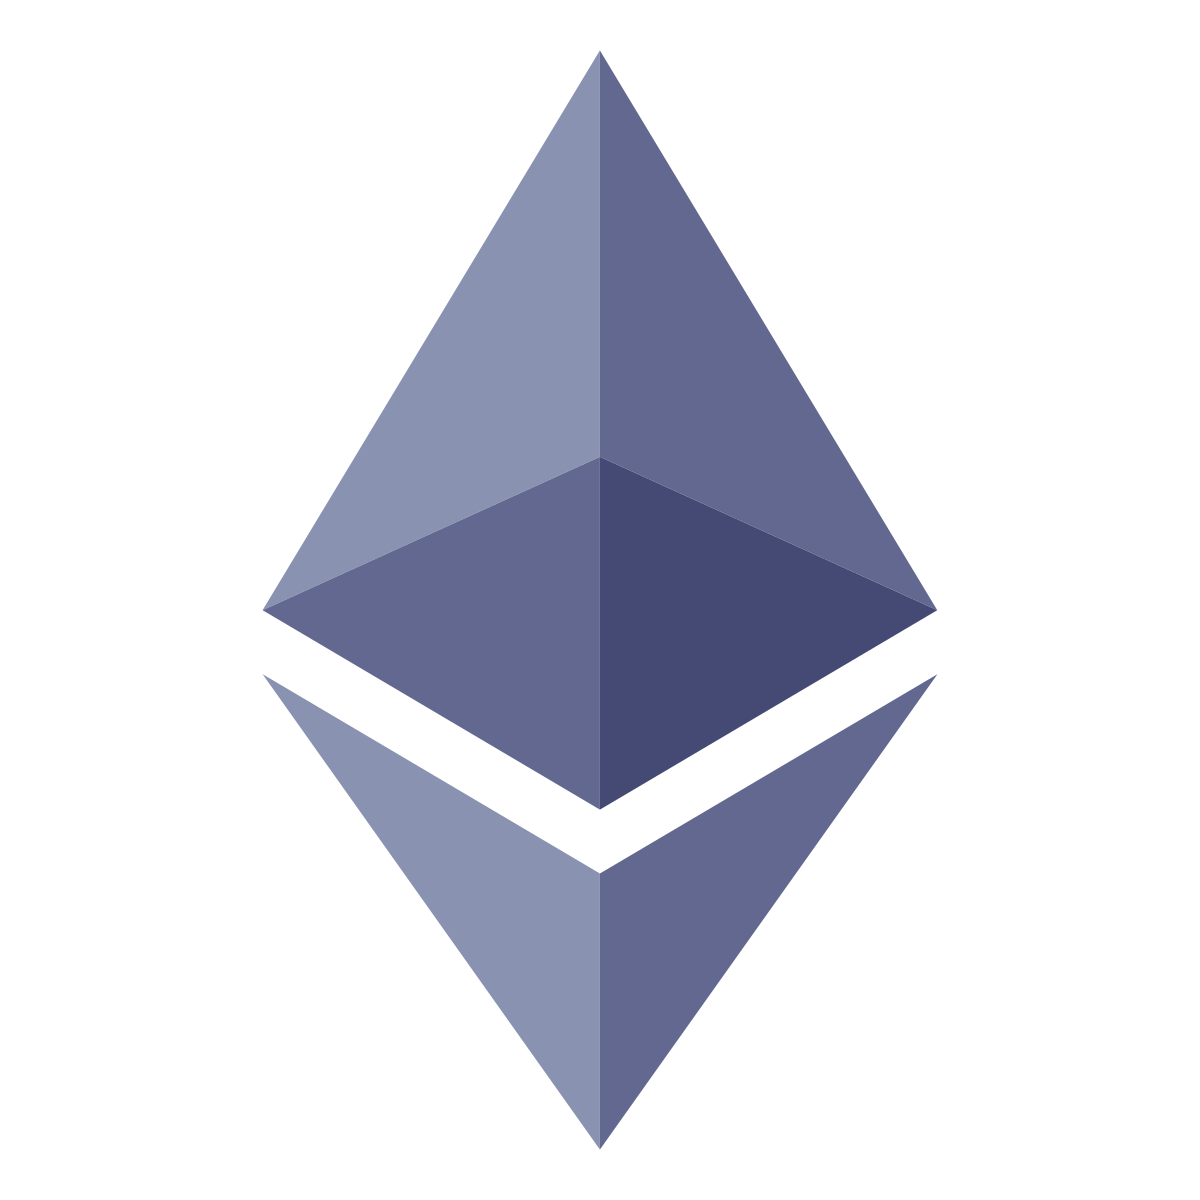

In [1]:
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('/kaggle/input/ethereum-frauddetection-dataset/transaction_dataset.csv').drop(columns=['Unnamed: 0'])
df.columns

Index(['Index', 'Address', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time betwe

In [2]:
# Create a list of columns that contain only zero values
columns_to_drop = []
for i in list(df.columns):
    if df[i].dropna().unique().tolist() == df[' ERC20 avg val sent contract'].dropna().unique().tolist():
        columns_to_drop.append(i)
columns_to_drop

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

In [3]:
# Create a list of columns to remove
col_del = ['Address','Index']+columns_to_drop
print(col_del)

['Address', 'Index', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']


In [4]:
# Removing unnecessary columns
df_new = df.drop(columns=col_del)

In [5]:
# Filling missing numeric values with their average
for i in list(df_new.columns):
  if i not in [' ERC20 most sent token type', ' ERC20_most_rec_token_type']:
    mean = np.mean(df_new[i])
    df_new[i] = df_new[i].fillna(mean)
df_new.isna().sum()

FLAG                                                       0
Avg min between sent tnx                                   0
Avg min between received tnx                               0
Time Diff between first and last (Mins)                    0
Sent tnx                                                   0
Received Tnx                                               0
Number of Created Contracts                                0
Unique Received From Addresses                             0
Unique Sent To Addresses                                   0
min value received                                         0
max value received                                         0
avg val received                                           0
min val sent                                               0
max val sent                                               0
avg val sent                                               0
min value sent to contract                                 0
max val sent to contract

In [6]:
# Filling missing non-numeric values with the most common instance
df_new[' ERC20_most_rec_token_type']=df_new[' ERC20_most_rec_token_type'].fillna('0')
df_new[' ERC20 most sent token type'] = df_new[' ERC20 most sent token type'].fillna('0')
df_new.isna().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

In [7]:
# Create category lists
features = list(set(df_new.columns) - set('FLAG'))
num_features = list(set(features) - set(df_new.dtypes[df.dtypes == 'object'].index))
cat_feature = list(set(features) - set(num_features))

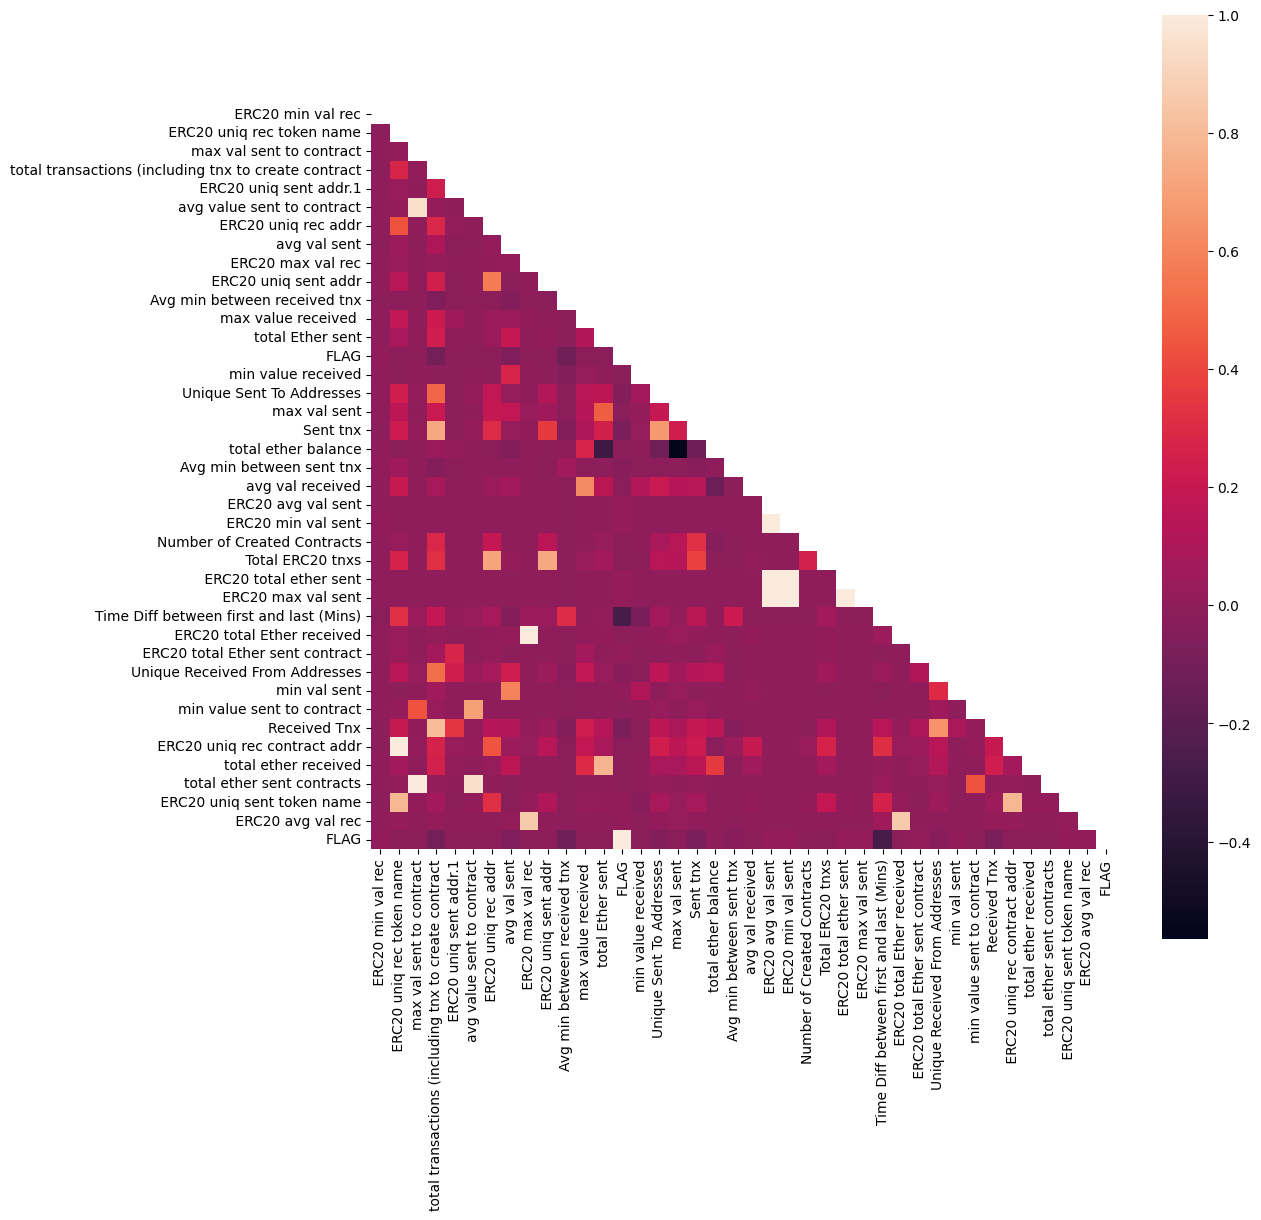

In [8]:
# Create a correlation map
corr = df_new[num_features + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [9]:
# Removing highly correlated variables
threshold = 0.8

high_corr_var = np.where((corr.abs() > threshold) & (corr.abs() < 1))
high_corr_pairs = [(corr.columns[x], corr.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

for (column1, column2) in high_corr_pairs:
    if column1 in df_new.columns and column2 in df_new.columns:
        df_new.drop(column2, axis=1, inplace=True)

df_new.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 min val rec', ' ERC20 max val rec',
       ' ERC20 avg val sent', ' ERC20 uniq sent token name',
       ' ERC20 uniq rec token name', ' ERC20 most sent token type',
       ' ERC20_most_rec_token_type'],
      dtype='object')

In [10]:
# Create a new category list
features = list(set(df_new.columns) - set('FLAG'))
num_features = list(set(features) - set(df_new.dtypes[df.dtypes == 'object'].index))
cat_feature = list(set(features) - set(num_features))

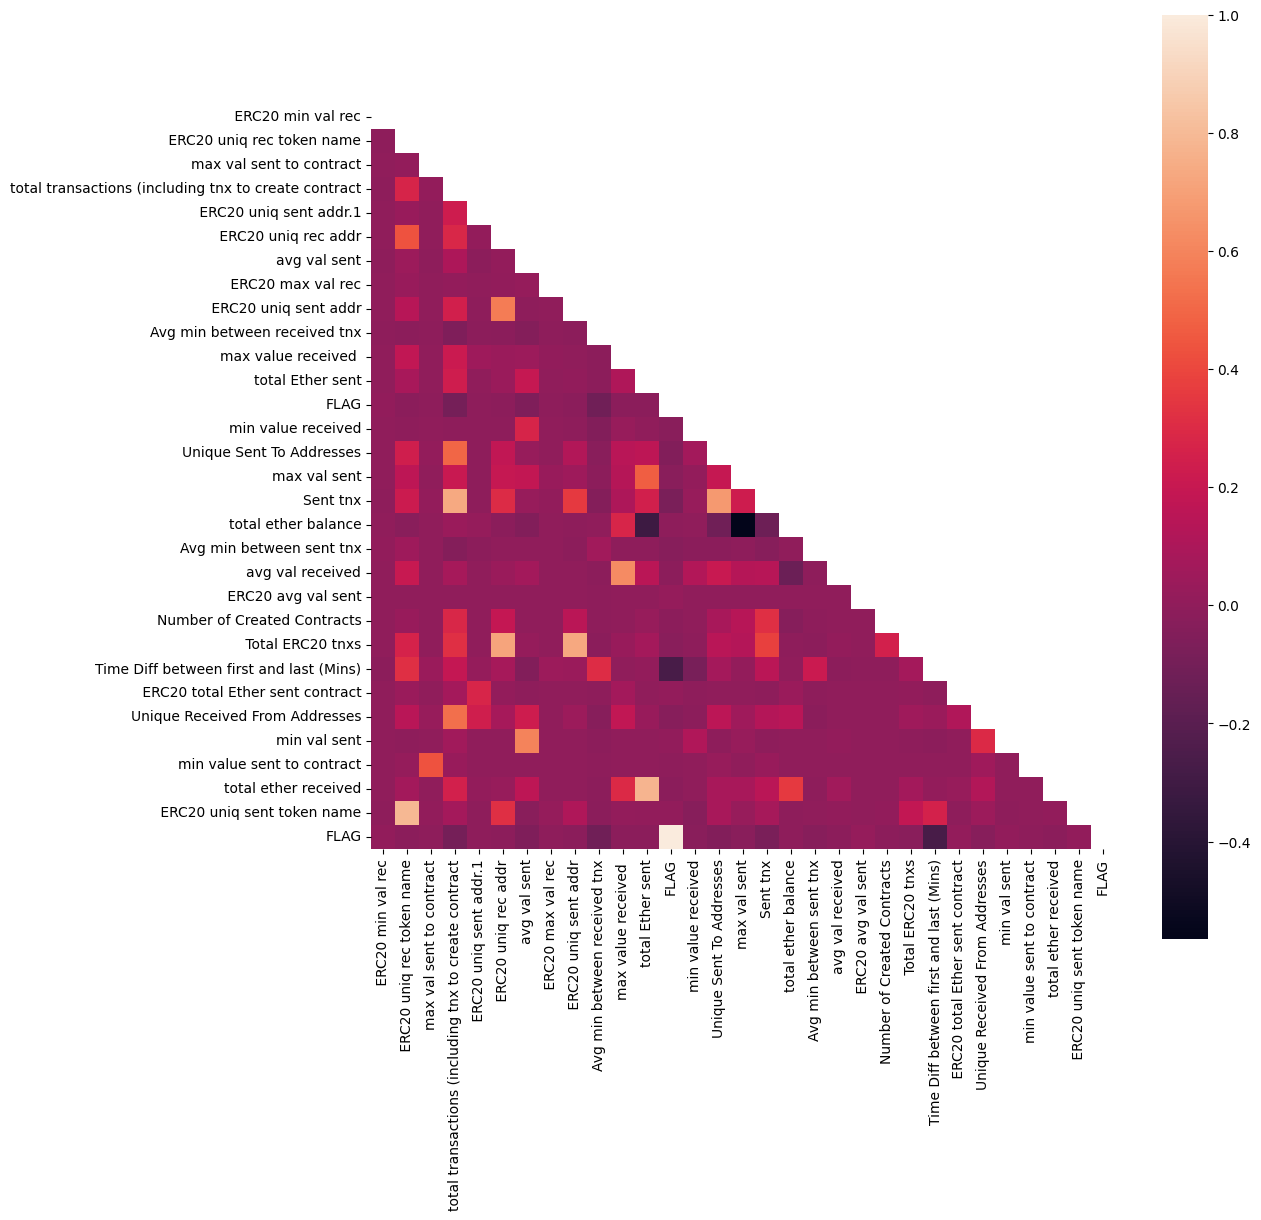

In [11]:
# Create a new correlation map
corr = df_new[num_features + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [12]:
# Unification of values
df_new[' ERC20_most_rec_token_type'] = df_new[' ERC20_most_rec_token_type'].replace(['None', ' ', None], '0')
df_new[' ERC20_most_rec_token_type'].unique()

array(['Numeraire', 'Livepeer Token', 'XENON', 'EOS', '0', 'AICRYPTO',
       'DATAcoin', 'PoSToken', 'KyberNetwork', 'Bancor', 'OmiseGO',
       'ONOT', 'Tronix', 'StatusNetwork',
       'SAFE.AD - 20% DISCOUNT UNTIL 1 MAY', 'Storj', 'bitqy',
       'Beauty Coin', 'SONM', 'NEVERDIE', 'INS Promo', 'TenXPay',
       'Cybereits Token', 'FunFair', 'DGD', 'iEx.ec Network Token',
       'AION', 'Aragon', 'Cofoundit', 'Golem', 'CRYPTOPUNKS', 'Nitro',
       'Ether Token', 'VeChain', 'Reputation', 'Intelion', 'Dochain',
       'SwarmCity', 'BAT', 'LockTrip', 'Humaniq', 'KickCoin', 'BOX Token',
       'MobileGo', 'Monaco', 'Azbit', 'Nexium', 'ZGC', 'www.pnztrust.com',
       'Send your ETH to this contract and earn 2.55% every day for Live-long. https://255eth.club',
       'empowr', 'An Etheal Promo', 'BitClave', 'Bytom',
       'Identity Hub Token', 'Celsius', 'Raiden', 'Trustcoin', 'ARP',
       'Qtum', 'Poker Chips', 'Loopring', 'Penta Network Token', 'Salt',
       'ICONOMI', 'Edgeless', 

In [13]:
# Replace categorical column values with 0 and 1
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_new[cat_feature])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(cat_feature), index=df_new.index)
df_new.drop(cat_feature, axis=1, inplace=True)
df_new = pd.concat([df_new, encoded_df], axis=1)
df_new.isna().sum()

FLAG                                           0
Avg min between sent tnx                       0
Avg min between received tnx                   0
Time Diff between first and last (Mins)        0
Sent tnx                                       0
                                              ..
 ERC20_most_rec_token_type_shellchains.com     0
 ERC20_most_rec_token_type_timereum            0
 ERC20_most_rec_token_type_vSlice              0
 ERC20_most_rec_token_type_www.pnztrust.com    0
 ERC20_most_rec_token_type_yocoinclassic       0
Length: 799, dtype: int64

In [14]:
# Data standardization
X = df_new.drop('FLAG', axis=1)
y = df_new['FLAG']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,...,ERC20_most_rec_token_type_iDAG SPACE,ERC20_most_rec_token_type_iEx.ec Network Token,ERC20_most_rec_token_type_iXledger,ERC20_most_rec_token_type_minereum,ERC20_most_rec_token_type_savedroid,ERC20_most_rec_token_type_shellchains.com,ERC20_most_rec_token_type_timereum,ERC20_most_rec_token_type_vSlice,ERC20_most_rec_token_type_www.pnztrust.com,ERC20_most_rec_token_type_yocoinclassic
0,-0.197465,-0.299436,1.506411,0.799099,-0.02637,0.032280,0.349346,-0.134530,-0.036696,-0.032626,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
1,0.354760,-0.218644,3.096367,-0.028965,-0.02637,-0.084931,-0.044882,-0.134530,-0.040016,-0.034777,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
2,11.221900,-0.241365,0.924051,-0.150467,-0.02637,-0.068187,-0.090370,-0.134183,-0.040128,-0.034786,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
3,0.238893,0.337091,0.555004,-0.120091,-0.02637,-0.078233,-0.048673,-0.134530,-0.001780,-0.000424,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
4,-0.235055,0.117108,0.508294,5.919361,-0.01930,-0.078233,-0.025929,-0.134530,-0.039233,-0.033985,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0.351318,-0.319467,-0.494191,-0.147826,-0.02637,-0.064838,-0.082788,-0.134518,-0.039295,-0.033933,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
9837,-0.236759,-0.346822,-0.676119,-0.153108,-0.02637,-0.101676,-0.097951,-0.134530,-0.040217,-0.034910,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
9838,-0.120427,-0.251968,0.133991,-0.064623,-0.02637,0.002140,0.068838,-0.134527,-0.038579,-0.034483,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081
9839,-0.236759,-0.346822,-0.676119,-0.153108,-0.02637,-0.098327,-0.097951,-0.132996,-0.040179,-0.034737,...,-0.010081,-0.010081,-0.010081,-0.022546,-0.010081,-0.017463,-0.010081,-0.010081,-0.057117,-0.010081


In [15]:
# Searching for the optimal number of components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_optimal = (total_explained_variance >= 0.95).argmax() + 1

n_components_optimal

558

In [16]:
# PCA execution with optimal number of components
pca_optimal = PCA(n_components=n_components_optimal)

X_pca_optimal = pca_optimal.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca_optimal, columns=[f'PC{i+1}' for i in range(X_pca_optimal.shape[1])])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC549,PC550,PC551,PC552,PC553,PC554,PC555,PC556,PC557,PC558
0,4.759594,-4.611529,-0.426085,0.518300,2.486159,-0.355608,0.447758,0.180450,0.066177,0.383308,...,0.742504,0.028583,-0.386357,3.291352,-0.329581,2.233961,-1.864953,-1.170447,-1.921309,-2.394145
1,0.994599,-2.205391,-0.016399,0.734301,-0.793544,0.225627,-2.424007,-0.136488,0.322836,0.024133,...,-0.769447,1.836718,-2.493866,-3.836719,-1.112526,-2.780614,4.315018,-0.211697,-2.651715,-1.356346
2,0.145853,-1.519511,-0.037129,0.369363,-0.059317,0.264919,-2.765820,-0.186477,1.114292,0.140736,...,0.015250,1.077477,0.553710,-0.874293,-0.027360,-0.422172,-0.613363,-1.006194,-0.854201,-1.460261
3,1.244601,-2.485612,-0.235228,0.479499,0.607083,-0.037468,-0.589416,-0.044358,0.416956,-0.006373,...,0.409178,1.305306,2.083720,2.346898,0.012607,-2.599742,1.133664,3.533576,-4.260735,1.234401
4,4.677025,-1.032150,-0.023644,1.240795,-0.198273,-0.202457,-2.250117,0.713252,-0.714908,-0.493631,...,1.587917,-1.211268,0.481610,-0.764288,-0.536270,0.970205,0.788773,-0.333507,0.164700,0.380354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,-0.119002,-1.505056,-0.148164,0.452810,-3.240678,-1.209649,1.477476,0.195206,-0.174882,0.031385,...,-0.113050,0.060283,0.083979,-0.070530,-0.126229,0.101378,0.137234,0.129236,0.040505,-0.159239
9837,-0.236997,-1.431463,-0.160839,0.390390,-3.465169,-1.361755,1.838528,0.258719,-0.313536,0.058451,...,0.009248,0.047044,0.015102,-0.015389,-0.047145,0.029011,0.083837,0.057485,-0.150798,-0.035436
9838,0.166600,-1.575853,-0.123068,0.547548,-3.035178,-1.069426,1.107199,0.170615,-0.188336,0.035298,...,0.538422,-1.116298,1.473857,2.051915,0.717661,1.839755,-2.117892,0.506158,1.816315,0.963723
9839,-0.727336,0.816010,-0.023307,-0.448822,0.690305,0.050182,0.408678,0.047529,-0.184864,0.062509,...,0.007591,-0.024269,-0.099697,0.043895,0.110593,-0.047458,0.045492,0.016317,0.062867,-0.068579


In [17]:
# Perform UnderSampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df_pca, y)

df_pca_balanced = pd.DataFrame(X_res, columns=df_pca.columns)
df_pca_balanced['FLAG'] = y_res

print(df_pca_balanced['FLAG'].value_counts())

FLAG
0    2179
1    2179
Name: count, dtype: int64


/tmp/ipykernel_18/2335181351.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pca_balanced['FLAG'] = y_res


In [18]:
# Preparing data for modeling
X = df_pca_balanced.drop('FLAG', axis=1)
y = df_pca_balanced['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [19]:
# Logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Accuracy dla Logistic Regression:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Accuracy dla Logistic Regression: 0.959480122324159
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       660
           1       0.95      0.97      0.96       648

    accuracy                           0.96      1308
   macro avg       0.96      0.96      0.96      1308
weighted avg       0.96      0.96      0.96      1308



In [20]:
# Random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Accuracy for Random Forest:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy for Random Forest: 0.9724770642201835
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       660
           1       0.99      0.96      0.97       648

    accuracy                           0.97      1308
   macro avg       0.97      0.97      0.97      1308
weighted avg       0.97      0.97      0.97      1308

